In [1]:
import torch
import json
import numpy as np
import pickle
from pathlib import Path

import matplotlib.pyplot as plt

from apelfei.utils.data_handling import load_adi_data
from s4hci.models.noise import S4Ridge

## Load the data

In [2]:
dataset_config_file = "/home/ipa/quanz/user_accounts/mbonse/2022_ALADIN/" \
                      "70_results/00_eps_eri_fake_planet_experiments/" \
                      "0100_C-0656-A/dataset.json"

with open(dataset_config_file) as json_file:
    dataset_config = json.load(json_file)

print("Loading data ... ", end='')
science_data, raw_angles, raw_psf_template_data = \
    load_adi_data(dataset_config["file_path"],
                  data_tag=dataset_config["stack_key"],
                  psf_template_tag=dataset_config["psf_template_key"],
                  para_tag=dataset_config["parang_key"])

psf_template_data = np.mean(raw_psf_template_data, axis=0)

X_train = science_data[0::2]
X_test = science_data[1::2]
print("[DONE]")

Loading data ... [DONE]


## Test different alphas

In [3]:
alphas = np.linspace(1000, 20000, 20)

In [4]:
alphas

array([ 1000.,  2000.,  3000.,  4000.,  5000.,  6000.,  7000.,  8000.,
        9000., 10000., 11000., 12000., 13000., 14000., 15000., 16000.,
       17000., 18000., 19000., 20000.])

In [ ]:
step_size = 5

test_errors = []
all_betas = []

ridge_model = S4Ridge(
    X_train,
    psf_template_data,
    normalize_data=True,
    alpha=-1,
    available_devices=[0, 1],
    half_precision=True)

best_error = np.inf
best_alpha = 10000000

for tmp_alpha in alphas:
    print("Testing alpha = " + str(tmp_alpha))
    ridge_model.alpha = tmp_alpha

    errors, betas = ridge_model.fit_and_validate(
        step_size=step_size,
        test_science_data=X_test)
    
    all_betas.append(betas)
    
    median_errors = np.median(errors, axis=0)
    test_errors.append((np.median(median_errors), median_errors))
    
    if np.median(median_errors) < best_error:
        best_error = np.median(median_errors)
        best_alpha = tmp_alpha

Creating masks ... [DONE]
Normalizing data ... [DONE]
Testing alpha = 1000.0


100%|██████████| 242/242 [05:15<00:00,  1.31s/it]


Testing alpha = 2000.0


 10%|▉         | 23/242 [00:31<04:48,  1.32s/it]

In [5]:
# save the results
root_save_dir = Path("/home/ipa/quanz/user_accounts/mbonse/2022_ALADIN/70_results/"
                     "s4_closed_form/01_validation_of_different_alphas/")

In [84]:
root_save_dir / "all_betas.pkl"

PosixPath('/home/ipa/quanz/user_accounts/mbonse/2022_ALADIN/70_results/s4_closed_form/01_validation_of_different_alphas/all_betas.pkl')

In [91]:
with open(root_save_dir / "01_all_betas.pkl", 'wb') as outp:
    pickle.dump(all_betas, outp, pickle.HIGHEST_PROTOCOL)
    
with open(root_save_dir / "01_test_errors.pkl", 'wb') as outp:
    pickle.dump(test_errors, outp, pickle.HIGHEST_PROTOCOL)

In [6]:
with open(root_save_dir / "01_all_betas.pkl", 'rb') as inp:
    all_betas = pickle.load(inp)
    
with open(root_save_dir / "01_test_errors.pkl", 'rb') as inp:
    test_errors = pickle.load(inp)

In [7]:
best_alpha = 6000.
best_alpha

6000.0

In [8]:
errors_col = [i[0] for i in test_errors]

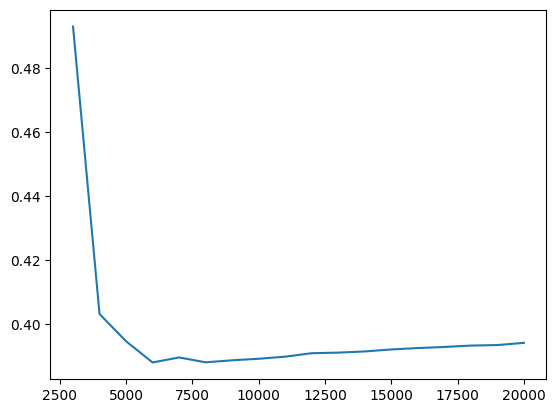

In [9]:
plt.plot(alphas[2:], np.array(errors_col)[2:])

# Interactive Beta Plots

In [10]:
from matplotlib import rcParams
import ipywidgets
from ipywidgets import interact
import IPython

In [11]:
rcParams['figure.figsize'] = (15, 6)

def generate_plots_(alpha,
                    idx):
    
    alpha_idx = np.where(alphas == alpha)[0][0]
    sel_beta = all_betas[alpha_idx][idx, :].reshape(107, 107)
    
    fig, ax = plt.subplots(1, 1)
    
    ax.imshow(torch.abs(sel_beta))
    ax.set_title("Alpha = " + str(alpha))
    
    plt.show()

# set up the interaction tools
alpha_slider = ipywidgets.IntSlider(
    value=int(best_alpha),
    min=int(np.min(alphas)),
    max=int(np.max(alphas)),
    step=1000,
    description='Alpha:',
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    readout=True,
    readout_format='d')

idx_slider = ipywidgets.IntSlider(
    description='Position idx:',
    value=0,
    min=0,
    max=all_betas[0].shape[0] - 1,
    step=1,
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    readout=True,
    readout_format='d')

interact(
    generate_plots_,
    alpha=alpha_slider,
    idx=idx_slider,
);

/scratch/user/mbonse/2022_ALADIN/venv_s4/lib/python3.10/site-packages/ipykernel/pylab/backend_inline.py:10: DeprecationWarning: `ipykernel.pylab.backend_inline` is deprecated, directly use `matplotlib_inline.backend_inline`
  warnings.warn(


interactive(children=(IntSlider(value=6000, description='Alpha:', max=20000, min=1000, step=1000), IntSlider(v…

# Final best model

In [ ]:
final_ridge_model = S4Ridge(
    X_train,
    psf_template_data,
    normalize_data=True,
    alpha=best_alpha,
    available_devices=[0, 1],
    half_precision=True)

In [ ]:
final_ridge_model.fit()

In [96]:
with open(root_save_dir / "02_final_ridge_model.pkl", 'wb') as outp:
    pickle.dump(final_ridge_model, outp, pickle.HIGHEST_PROTOCOL)

In [12]:
with open(root_save_dir / "02_final_ridge_model.pkl", 'rb') as inp:
    final_ridge_model = pickle.load(inp)

In [13]:
rcParams['figure.figsize'] = (15, 6)

def generate_plots_(x, y):
    
    idx = x*107 + y
    
    tmp_betas = final_ridge_model.betas[idx, :]
    tmp_betas = tmp_betas.reshape(107, 107)
    
    fig, ax = plt.subplots(1, 1)
    
    ax.imshow(torch.abs(tmp_betas))
    
    plt.show()

# set up the interaction tools
x_slider = ipywidgets.IntSlider(
    description='X Position:',
    value=0,
    min=0,
    max=106,
    step=1,
    continuous_update=True,
    orientation='horizontal',
    readout=True,
    readout_format='d')

y_slider = ipywidgets.IntSlider(
    description='Y Position:',
    value=0,
    min=0,
    max=106,
    step=1,
    continuous_update=True,
    orientation='horizontal',
    readout=True,
    readout_format='d')

interact(
    generate_plots_,
    x=x_slider,
    y=y_slider,
);

interactive(children=(IntSlider(value=0, description='X Position:', max=106), IntSlider(value=0, description='…